## voc-seg

训练集：加载了 209 张图片和标签,过滤了0张图片
测试集：加载了 210 张图片和标签,过滤了6张图片
torch.Size([3, 281, 500])
torch.Size([281, 500]) tensor(0) tensor(15)
img.shape=(562, 1000, 3)  img.min()=0  img.max()=255


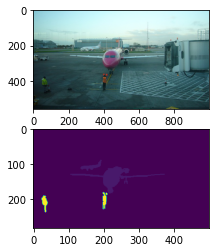

In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset
import numpy as np
import os
from PIL import Image
from datetime import datetime
 
 
 
class VOC_SEG(Dataset):
    def __init__(self, root, width, height, train=True, transforms=None):
        # 图像统一剪切尺寸（width, height）
        self.width = width
        self.height = height
        # VOC数据集中对应的标签
        self.classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
        # 各种标签所对应的颜色
        self.colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]
        # 辅助变量
        self.fnum = 0
        if transforms is None:
            normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            self.transforms = T.Compose([
                T.ToTensor(),
                # normalize
            ])
        # 像素值(RGB)与类别label(0,1,3...)一一对应
        self.cm2lbl = np.zeros(256**3)
        for i, cm in enumerate(self.colormap):
            self.cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i
 
        
        if train:
            txt_fname = root+"/ImageSets/Segmentation/train.txt"
        else:
            txt_fname = root+"/ImageSets/Segmentation/val.txt"
        with open(txt_fname, 'r') as f:
            images = f.read().split()
        imgs = [os.path.join(root, "JPEGImages", item+".jpg") for item in images]
        labels = [os.path.join(root, "SegmentationClass", item+".png") for item in images]
        self.imgs = self._filter(imgs)
        self.labels = self._filter(labels)
        if train:
            print("训练集：加载了 " + str(len(self.imgs)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        else:
            print("测试集：加载了 " + str(len(self.imgs)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
 
    def _crop(self, data, label):
        """
        切割函数，默认都是从图片的左上角开始切割。切割后的图片宽是width,高是height
        data和label都是Image对象
        """
        box = (0,0,self.width,self.height)
        data = data.crop(box)
        label = label.crop(box)
        return data, label
 
    def _image2label(self, im):
        data = np.array(im, dtype="int32")
        idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
        return np.array(self.cm2lbl[idx], dtype="int64")
        
    def _image_transforms(self, data, label):
        # data, label = self._crop(data,label)
        data = self.transforms(data)
        label = self._image2label(label)
        label = torch.from_numpy(label)
        return data, label
 
    def _filter(self, imgs): 
        img = []
        for im in imgs:
            if (Image.open(im).size[1] >= self.height and 
               Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum  = self.fnum+1
        return img
 
    def __getitem__(self, index: int):
        img_path = self.imgs[index]
        label_path = self.labels[index]
        img = Image.open(img_path)
        label = Image.open(label_path).convert("RGB")
        img, label = self._image_transforms(img, label)
        return img, label
 
    def __len__(self) :
        return len(self.imgs)
 
 

import matplotlib.pyplot as plt
import cv2

if __name__=="__main__":
    root = "/data/ylw/datasets/voc/VOC2007"
    height = 224
    width = 224
    voc_train = VOC_SEG(root, width, height, train=True)
    voc_test = VOC_SEG(root, width, height, train=False)
 
    # train_data = DataLoader(voc_train, batch_size=8, shuffle=True)
    # valid_data = DataLoader(voc_test, batch_size=8)
    fig, axes = plt.subplots(nrows=2, ncols=1)
    for data, label in voc_train:
        print(data.shape)
        print(label.shape, label.min(), label.max())
        img = data.numpy().transpose((1,2,0))#[:, :, ::-1]
        img = cv2.resize(img*255, (img.shape[1]*2, img.shape[0]*2)).astype(np.uint8)
        label = label.numpy()
        print(f'{img.shape=}  {img.min()=}  {img.max()=}')
        axes[0].imshow(img);
        axes[1].imshow(label);
        
        break
